In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import trimesh

from torch import optim
from torch.nn import Conv1d
from torch.nn import Flatten
from torch.nn import Linear
from torch.nn import MaxPool1d
from torch.utils.data import TensorDataset, DataLoader

from models import Net7, Net12, ConvNet
from utils import loss_graph, train

# Load mesh objects

**Show figures**

In [2]:
mesh_cube = trimesh.load('data/cube.obj')
mesh_cube.show(viewer='notebook', smooth=False)

In [3]:
mesh_pyramid = trimesh.load('data/pyramid.obj')
mesh_pyramid.show(viewer='notebook', smooth=False)

In [4]:
mesh_teddy = trimesh.load('data/teddy.obj')
mesh_teddy.show(viewer='notebook', smooth=False)

In [5]:
mesh_chair = trimesh.load('data/chair.obj')
mesh_chair.show(viewer='notebook', smooth=False)

**Load points**

In [6]:
mesh_cube_bb = np.array(mesh_cube.bounding_box.vertices)
mesh_pyramid_bb = np.array(mesh_pyramid.bounding_box.vertices)
mesh_teddy_bb = np.array(mesh_teddy.bounding_box.vertices)
mesh_chair_bb = np.array(mesh_chair.bounding_box.vertices)

**Create dataset**

In [7]:
bbs = {
    "cube": mesh_cube_bb,
    "pyramid": mesh_pyramid_bb,
    "teddy": mesh_teddy_bb,
    "chair": mesh_chair_bb    
}

meshs = {
    "cube": mesh_cube,
    "pyramid": mesh_pyramid,
    "teddy": mesh_teddy,
    "chair": mesh_chair
}

datasets = {}


for key, value in bbs.items():    
    min_x, max_x = np.amin(value.T[0]), np.amax(value.T[0])
    min_y, max_y = np.amin(value.T[1]), np.amax(value.T[1])
    min_z, max_z = np.amin(value.T[2]), np.amax(value.T[2])

    DELTA = 5
    POINTS_NUMDER = 20
    points_train = np.float_([
        [x_, y_, z_] for z_ in np.linspace(min_z-DELTA, max_z+DELTA, POINTS_NUMDER) 
        for y_ in np.linspace(min_y-DELTA, max_y+DELTA, POINTS_NUMDER) 
        for x_ in np.linspace(min_x-DELTA, max_x+DELTA, POINTS_NUMDER)
    ])
    
    print(f"- {key} points train shape: {points_train.shape}")
    sdf_data = np.array([-1*p for p in meshs[key].nearest.signed_distance(points_train)])
    
    train_ds = TensorDataset(torch.Tensor(points_train), torch.Tensor(sdf_data))
    train_dl = DataLoader(train_ds, shuffle=True, batch_size=len(train_ds))
    datasets[key] = train_dl
    

# datasets

- cube points train shape: (8000, 3)
- pyramid points train shape: (8000, 3)
- teddy points train shape: (8000, 3)
- chair points train shape: (8000, 3)


# Train models

In [8]:
losses = {}

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(8, 6)})

torch.cuda.empty_cache()

### FC model 7-layer

In [9]:
net7 = Net7()
net7

Net7(
  (fc1): Linear(in_features=3, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=200, bias=True)
  (fc5): Linear(in_features=200, out_features=200, bias=True)
  (fc6): Linear(in_features=200, out_features=200, bias=True)
  (fc7): Linear(in_features=200, out_features=1, bias=True)
)

In [10]:
for name, dataloader in datasets.items():
    print(f">Train model for *{name}* dataset..")
    losses[f'net7_{name}']  = train(net7, train_dl, 5, 2)
    print(" Saveing model.. OK.")
    torch.save(net7, f"models/net7_{name}.pt")
    torch.cuda.empty_cache()
    print()

>Train model for *cube* dataset..
 Train Epoch: 2 Time: 00:00:00 Loss: 7.3484
 Train Epoch: 4 Time: 00:00:00 Loss: 6.5342
 Saveing model.. OK.

>Train model for *pyramid* dataset..
 Train Epoch: 2 Time: 00:00:00 Loss: 3.6778
 Train Epoch: 4 Time: 00:00:00 Loss: 3.584
 Saveing model.. OK.

>Train model for *teddy* dataset..
 Train Epoch: 2 Time: 00:00:00 Loss: 4.1414
 Train Epoch: 4 Time: 00:00:00 Loss: 3.4056
 Saveing model.. OK.

>Train model for *chair* dataset..
 Train Epoch: 2 Time: 00:00:00 Loss: 4.2241
 Train Epoch: 4 Time: 00:00:00 Loss: 3.3536
 Saveing model.. OK.



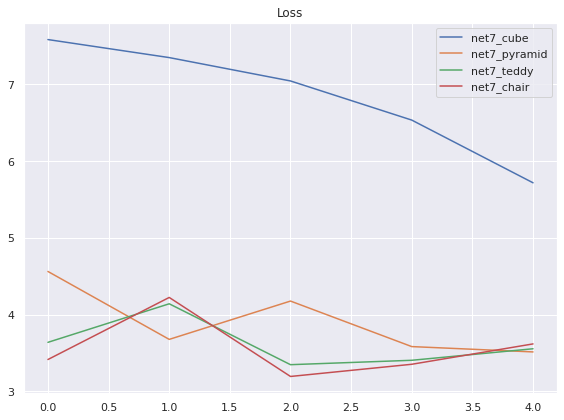

In [11]:
plots = filter(lambda x: x.startswith('net7'), losses.keys())
loss_graph(losses, list(plots))

In [12]:
losses.keys()

dict_keys(['net7_cube', 'net7_pyramid', 'net7_teddy', 'net7_chair'])

### FC model 12-layer

In [13]:
net12 = Net12()
net12

Net12(
  (fc1): Linear(in_features=3, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=200, bias=True)
  (fc5): Linear(in_features=200, out_features=200, bias=True)
  (fc6): Linear(in_features=200, out_features=200, bias=True)
  (fc7): Linear(in_features=200, out_features=200, bias=True)
  (fc8): Linear(in_features=200, out_features=200, bias=True)
  (fc9): Linear(in_features=200, out_features=200, bias=True)
  (fc10): Linear(in_features=200, out_features=200, bias=True)
  (fc11): Linear(in_features=200, out_features=200, bias=True)
  (fc12): Linear(in_features=200, out_features=1, bias=True)
)

In [14]:
for name, dataloader in datasets.items():
    print(f">Train model for *{name}* dataset..")
    losses[f'net12_{name}']  = train(net12, train_dl, 5, 2)
    print(" Saveing model.. OK.")
    torch.save(net12, f"models/net12_{name}.pt")
    torch.cuda.empty_cache()
    print('\n')

>Train model for *cube* dataset..
 Train Epoch: 2 Time: 00:00:00 Loss: 7.5791
 Train Epoch: 4 Time: 00:00:00 Loss: 7.5071
 Saveing model.. OK.


>Train model for *pyramid* dataset..
 Train Epoch: 2 Time: 00:00:00 Loss: 6.7557
 Train Epoch: 4 Time: 00:00:00 Loss: 3.6143
 Saveing model.. OK.


>Train model for *teddy* dataset..
 Train Epoch: 2 Time: 00:00:00 Loss: 4.6972
 Train Epoch: 4 Time: 00:00:00 Loss: 4.9614
 Saveing model.. OK.


>Train model for *chair* dataset..
 Train Epoch: 2 Time: 00:00:00 Loss: 9.7347
 Train Epoch: 4 Time: 00:00:00 Loss: 4.1693
 Saveing model.. OK.




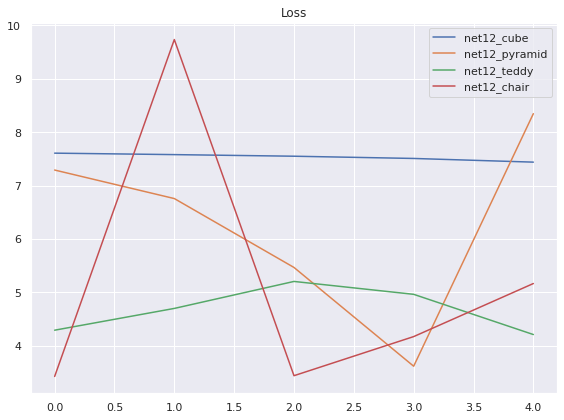

In [15]:
plots = filter(lambda x: x.startswith('net12'), losses.keys())
loss_graph(losses, list(plots))

### ConvNet

In [16]:
cnn = ConvNet()
cnn

ConvNet(
  (input_layer): Conv1d(3, 10, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(10, 50, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=50, out_features=50, bias=True)
  (output_layer): Linear(in_features=50, out_features=1, bias=True)
)

In [17]:
for name, dataloader in datasets.items():
    print(f">Train model for *{name}* dataset..")
    losses[f'cnn_{name}']  = train(cnn, train_dl, 5, 2)
    print(" Saveing model.. OK.")
    torch.save(cnn, f"models/cnn_{name}.pt")
    torch.cuda.empty_cache()
    print('\n')

>Train model for *cube* dataset..
 Train Epoch: 2 Time: 00:00:00 Loss: 6.3471
 Train Epoch: 4 Time: 00:00:00 Loss: 5.4395
 Saveing model.. OK.


>Train model for *pyramid* dataset..
 Train Epoch: 2 Time: 00:00:00 Loss: 4.3186
 Train Epoch: 4 Time: 00:00:00 Loss: 3.8373
 Saveing model.. OK.


>Train model for *teddy* dataset..
 Train Epoch: 2 Time: 00:00:00 Loss: 3.6194
 Train Epoch: 4 Time: 00:00:00 Loss: 3.574
 Saveing model.. OK.


>Train model for *chair* dataset..
 Train Epoch: 2 Time: 00:00:00 Loss: 3.5295
 Train Epoch: 4 Time: 00:00:00 Loss: 3.4944
 Saveing model.. OK.




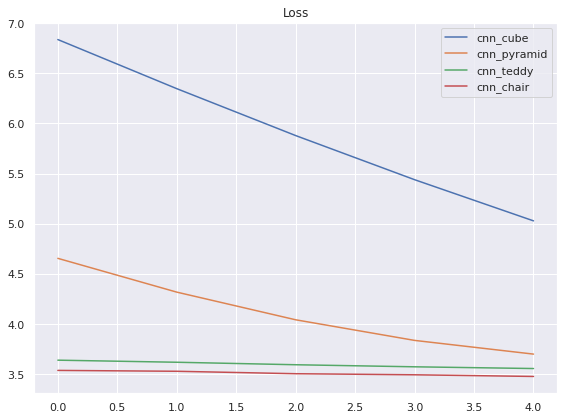

In [18]:
plots = filter(lambda x: x.startswith('cnn'), losses.keys())
loss_graph(losses, list(plots))

### Compare all plots

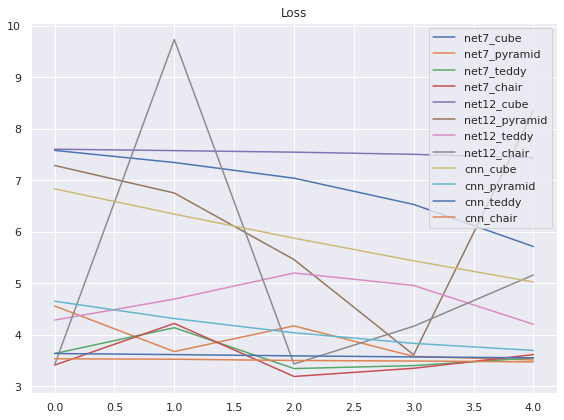

In [19]:
loss_graph(losses, losses.keys())

### Tiny check

In [20]:
idx = 1
xyz, sdf = points_train[idx], sdf_data[idx]
print("xyz:", xyz)
print("SDF:", sdf)

xyz: [-13.88612863  -5.007232   -25.904396  ]
SDF: 9.871933656875491


In [21]:
net7.cpu()
net12.cpu()
cnn.cpu()

output_net7 = net7(torch.Tensor(xyz)).item()
output_net12 = net12(torch.Tensor(xyz)).item()
output_cnn = cnn(torch.Tensor(xyz)).item()

print("net7 output: ", output_net7)
print("net12 output: ", output_net12)
print("cnn output: ", output_cnn)

net7 output:  6.643716812133789
net12 output:  2.524432897567749
cnn output:  8.470258712768555


# TODO:
 - ~~fix shapes for Net model~~
 - improve loss func
 - ~~prepare dats for ConvNet and train ConvNet~~